# Ensemble (Spatial + Temporal) — Jupyter notebook
Goal: combine spatial and temporal video-level scores using a calibrated logistic regression (Platt scaling).
Inputs expected (project root):
- `embeddings/<split>/*.npy` (T x feat_dim)  — produced by your extract_embeddings notebook
- `checkpoints/spatial_best_valAUC.pth` (or spatial_last)
- `checkpoints/temporal_best_valAUC.pth` (or temporal_last)
- `data/labels.json` mapping `video_stem -> 0/1`

Steps:
1. Load labels
2. Load spatial head (from spatial checkpoint) and compute per-frame logits from saved embeddings → aggregate per-video (mean, max, median)
3. Load temporal model checkpoint and compute per-video temporal logits (one forward per video)
4. Build feature table, train logistic regression on train set, calibrate on val (Platt)
5. Evaluate on train/val/test and plot ROC
6. Save ensemble model(s)

In [1]:
# Cell 2 - imports & config
from pathlib import Path
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

# ---- USER CONFIG: edit paths if needed ----
ROOT = Path.cwd().parent        # adjust if your notebook sits in a subfolder
EMB_ROOT = ROOT / "embeddings"
LABELS_JSON = ROOT / "data" / "labels.json"
SPATIAL_CKPT = ROOT / "checkpoints" / "spatial" / "spatial_best_valAUC.pth"
TEMPORAL_CKPT = ROOT / "checkpoints" / "temporal" / "temporal_best_valAUC.pth"

SPLITS = ["train", "val", "test"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 64   # batch for processing frame embeddings through head

print("ROOT:", ROOT)
print("Embeddings dir:", EMB_ROOT)
print("Spatial ckpt:", SPATIAL_CKPT)
print("Temporal ckpt:", TEMPORAL_CKPT)
print("Device:", DEVICE)

ROOT: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC
Embeddings dir: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\embeddings
Spatial ckpt: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\checkpoints\spatial\spatial_best_valAUC.pth
Temporal ckpt: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\checkpoints\temporal\temporal_best_valAUC.pth
Device: cuda


In [2]:
# Cell 3 - model wrappers used only for inference on embeddings

class SpatialHead(nn.Module):
    """
    Head part of the spatial model (maps backbone features -> 1 logit).
    Must match the head used in your train_spatial code (hidden=512, dropout=0.4).
    We'll load head weights from the saved full spatial checkpoint.
    """
    def __init__(self, feat_dim, head_hidden=512, dropout=0.4):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(feat_dim, head_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1)
        )
    def forward(self, feats):
        return self.head(feats).squeeze(-1)   # returns logits [N]

class TemporalModel(nn.Module):
    """
    Copy of the TemporalModel definition used during training.
    Only used for inference here (loads checkpoint).
    """
    def __init__(self, feat_dim, hidden_dim=512, n_layers=2, bidirectional=True, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(feat_dim, hidden_dim, n_layers, batch_first=True,
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers>1 else 0)
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.att = nn.Linear(out_dim, 1)
        self.head = nn.Sequential(
            nn.Linear(out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    def forward(self, x, lengths):
        # x: [B, T, feat], lengths: [B]
        # sort by length desc
        lengths_sorted, perm = lengths.sort(descending=True)
        x_sorted = x[perm]
        packed = rnn_utils.pack_padded_sequence(x_sorted, lengths_sorted.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, _ = self.lstm(packed)
        out_un, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        # unsort
        _, unperm = perm.sort()
        out = out_un[unperm]   # [B, Tmax, H]
        lengths = lengths[unperm]
        # attention pooling
        scores = self.att(out).squeeze(-1)   # [B, T]
        mask = torch.arange(out.size(1), device=out.device).unsqueeze(0) >= lengths.unsqueeze(1)
        scores = scores.masked_fill(mask, -1e9)
        weights = torch.softmax(scores, dim=1)
        pooled = (out * weights.unsqueeze(-1)).sum(dim=1)  # [B, H]
        logits = self.head(pooled).squeeze(-1)
        return logits

In [3]:
# Cell 4 - labels
with open(LABELS_JSON, "r") as f:
    labels_map = json.load(f)

def get_label_by_stem(stem):
    if stem in labels_map:
        return int(labels_map[stem])
    for k,v in labels_map.items():
        if stem in k:
            return int(v)
    raise KeyError(f"Label for stem '{stem}' not found in labels.json")

In [4]:
# Cell 5 - load spatial ckpt and create spatial head inference function
ckpt = torch.load(SPATIAL_CKPT, map_location="cpu")   # load on CPU, move later
state = ckpt.get("model_state", ckpt)

# infer feat_dim by checking a backbone weight or by inspecting embeddings if needed
# We'll try to infer feat_dim from state dict keys like 'backbone.conv_head.weight' or from embeddings
feat_dim = None
for k in state.keys():
    if "backbone" in k and k.endswith("num_features"):  # unlikely
        pass
# fallback: use an embedding file to read feat_dim
sample_emb_file = next((EMB_ROOT / "train").glob("*.npy"))
sample_arr = np.load(sample_emb_file)
feat_dim = sample_arr.shape[1]
print("Inferred feat_dim from embeddings:", feat_dim)

# create spatial head and load its params from the checkpoint
sp_head = SpatialHead(feat_dim).to(DEVICE)
# build head_state expected keys likely like 'head.0.weight' etc. In the checkpoint they were saved under model_state with those names.
# So attempt to extract keys beginning with 'head.' and load into sp_head
head_state = {}
for k,v in state.items():
    if k.startswith("head."):
        newk = k  # same names if our module uses 'head'
        head_state[newk] = v
# try load (some checkpoints may have 'module.' prefixes)
try:
    sp_head.load_state_dict(head_state, strict=True)
    print("Loaded spatial head from checkpoint.")
except Exception as e:
    # attempt to strip possible prefixes like 'module.' or 'model.'
    fixed = {k.replace("module.", "").replace("model.", ""): v for k,v in head_state.items()}
    sp_head.load_state_dict(fixed, strict=False)
    print("Loaded spatial head with relaxed matching (some keys ignored).")
sp_head.eval()

Inferred feat_dim from embeddings: 1536
Loaded spatial head from checkpoint.


SpatialHead(
  (head): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [5]:
# Cell 6 - per-video spatial aggregation
import math
from statistics import median

def compute_spatial_video_stats(emb_path, head_model, device=DEVICE, batch=BATCH):
    """
    emb_path: Path to .npy (T x feat_dim)
    returns dict: mean_prob, max_prob, median_prob, std_prob, mean_logit
    """
    arr = np.load(emb_path).astype(np.float32)
    if arr.size == 0:
        raise ValueError("Empty embedding: " + str(emb_path))
    # process in batches through head (head expects torch tensor)
    probs = []
    with torch.no_grad():
        for i in range(0, arr.shape[0], batch):
            block = torch.from_numpy(arr[i:i+batch]).to(device)   # [b, feat]
            logits = head_model(block)    # [b]
            p = torch.sigmoid(logits).detach().cpu().numpy()
            probs.append(p)
    probs = np.concatenate(probs, axis=0)
    stats = {
        "sp_mean_prob": float(np.nanmean(probs)),
        "sp_max_prob" : float(np.nanmax(probs)),
        "sp_median_prob": float(np.median(probs)),
        "sp_std_prob": float(np.nanstd(probs)),
        "sp_mean_logit": float(np.nanmean(np.log(np.clip(probs,1e-8,1-1e-8)/(1-np.clip(probs,1e-8,1-1e-8)))))  # mean of logit (safely)
    }
    return stats

In [6]:
# Cell 7 - load temporal model checkpoint
ck_tmp = torch.load(TEMPORAL_CKPT, map_location="cpu")
t_state = ck_tmp.get("model_state", ck_tmp)

# instantiate temporal model with known feat_dim and hyperparams matching training
TEMP_MODEL = TemporalModel(feat_dim=feat_dim, hidden_dim=512, n_layers=2, bidirectional=True, dropout=0.3).to(DEVICE)
# load weights (t_state keys must match)
try:
    TEMP_MODEL.load_state_dict(t_state, strict=False)
    print("Loaded temporal checkpoint into TEMP_MODEL (strict=False).")
except Exception as e:
    print("Warning loading temporal ckpt:", e)
TEMP_MODEL.eval()

def compute_temporal_logit_for_video(emb_path, model=TEMP_MODEL, device=DEVICE):
    arr = np.load(emb_path).astype(np.float32)
    if arr.size == 0:
        raise ValueError("Empty embedding: " + str(emb_path))
    x = torch.from_numpy(arr).unsqueeze(0).to(device)   # [1, T, feat]
    lengths = torch.tensor([arr.shape[0]], dtype=torch.long, device=device)
    with torch.no_grad():
        logits = model(x, lengths)   # returns [B] shape (1,)
    return float(logits.detach().cpu().numpy()[0])

Loaded temporal checkpoint into TEMP_MODEL (strict=False).


In [7]:
# Cell 8 - build dataframe of features
rows = []
for split in SPLITS:
    split_dir = EMB_ROOT / split
    if not split_dir.exists():
        print("Skipping missing split:", split)
        continue
    stems = sorted([p.stem for p in split_dir.glob("*.npy")])
    print(f"{split}: {len(stems)} videos found")
    for stem in tqdm(stems, desc=f"Feat build {split}"):
        p = split_dir / f"{stem}.npy"
        try:
            sp_stats = compute_spatial_video_stats(p, sp_head, device=DEVICE)
            tmp_logit = compute_temporal_logit_for_video(p, model=TEMP_MODEL, device=DEVICE)
            label = get_label_by_stem(stem)
        except Exception as e:
            print(f"Error processing {p}: {e}")
            continue
        row = {
            "split": split,
            "stem": stem,
            "label": label,
            "tmp_logit": tmp_logit,
            **sp_stats
        }
        rows.append(row)

df = pd.DataFrame(rows)
print("Feature dataframe shape:", df.shape)
display(df.head())

train: 4066 videos found


Feat build train:   0%|          | 1/4066 [00:00<13:00,  5.21it/s]C:\Users\lkmah\AppData\Local\Temp\ipykernel_33616\2639253861.py:27: RuntimeWarning: divide by zero encountered in divide
  "sp_mean_logit": float(np.nanmean(np.log(np.clip(probs,1e-8,1-1e-8)/(1-np.clip(probs,1e-8,1-1e-8)))))  # mean of logit (safely)
Feat build train: 100%|██████████| 4066/4066 [00:08<00:00, 470.31it/s]


val: 761 videos found


Feat build val: 100%|██████████| 761/761 [00:01<00:00, 502.23it/s]


test: 255 videos found


Feat build test: 100%|██████████| 255/255 [00:00<00:00, 495.61it/s]

Feature dataframe shape: (5082, 9)


,split,stem,label,tmp_logit,sp_mean_prob,sp_max_prob,sp_median_prob,sp_std_prob,sp_mean_logit
0,train,000,1,6.806530,0.948205,0.994730,9.796171e-01,0.088707,3.793336
1,train,000_003,1,9.988762,0.995534,1.000000,9.985341e-01,0.005364,inf
2,train,001,0,-11.848303,0.036469,0.289718,3.408732e-07,0.095721,-12.066820
3,train,003,0,-12.712004,0.000001,0.000010,3.090559e-14,0.000003,-16.750303
4,train,003_000,1,10.618320,0.999729,1.000000,9.999961e-01,0.000662,inf


In [8]:
# Cell 9 - prepare X, y arrays
# Choose simple features: spatial mean prob and temporal prob (sigmoid(tmp_logit))
df["tmp_prob"] = 1.0 / (1.0 + np.exp(-df["tmp_logit"]))
# Useful features
FEATURES = ["sp_mean_prob", "sp_max_prob", "sp_median_prob", "sp_std_prob", "tmp_prob"]

train_df = df[df["split"]=="train"].reset_index(drop=True)
val_df   = df[df["split"]=="val"].reset_index(drop=True)
test_df  = df[df["split"]=="test"].reset_index(drop=True)

X_train = train_df[FEATURES].values
y_train = train_df["label"].values.astype(int)
X_val = val_df[FEATURES].values
y_val = val_df["label"].values.astype(int)
X_test = test_df[FEATURES].values
y_test = test_df["label"].values.astype(int)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)

Train shape: (4066, 5) Val shape: (761, 5) Test shape: (255, 5)


In [9]:
# Cell 10 - train base LR, then calibrate on val using cv='prefit' (Platt)
base = LogisticRegression(solver="liblinear", C=1.0, class_weight=None, max_iter=1000, random_state=42)
base.fit(X_train, y_train)
print("Base LR trained.")

# evaluate base
def eval_print(clf, X, y, tag="set"):
    probs = clf.predict_proba(X)[:,1]
    aucv = roc_auc_score(y, probs)
    print(f"{tag} AUC: {aucv:.4f}")
    return probs, aucv

p_train_base, train_auc_base = eval_print(base, X_train, y_train, "Train (base)")
p_val_base, val_auc_base = eval_print(base, X_val, y_val, "Val   (base)")
p_test_base, test_auc_base = eval_print(base, X_test, y_test, "Test  (base)")

# Calibrate using validation set (Platt scaling)
calibrator = CalibratedClassifierCV(base, method="sigmoid", cv="prefit")
calibrator.fit(X_val, y_val)   # fits a sigmoid on val
print("Calibrator (Platt) fitted on val set.")

p_train_cal, train_auc_cal = eval_print(calibrator, X_train, y_train, "Train (calibrated)")
p_val_cal, val_auc_cal = eval_print(calibrator, X_val, y_val, "Val   (calibrated)")
p_test_cal, test_auc_cal = eval_print(calibrator, X_test, y_test, "Test  (calibrated)")

Base LR trained.
Train (base) AUC: 1.0000
Val   (base) AUC: 0.9916
Test  (base) AUC: 0.9902
Calibrator (Platt) fitted on val set.
Train (calibrated) AUC: 1.0000
Val   (calibrated) AUC: 0.9916
Test  (calibrated) AUC: 0.9902


c:\Users\lkmah\AppData\Local\Programs\anaconda3\envs\aiml\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


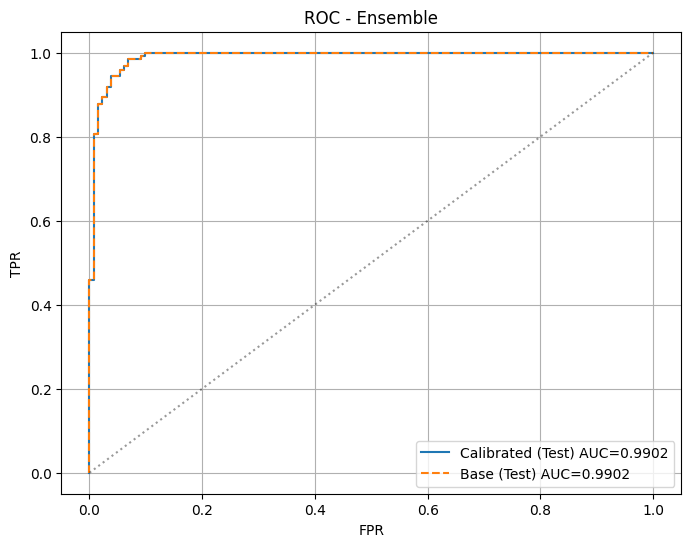

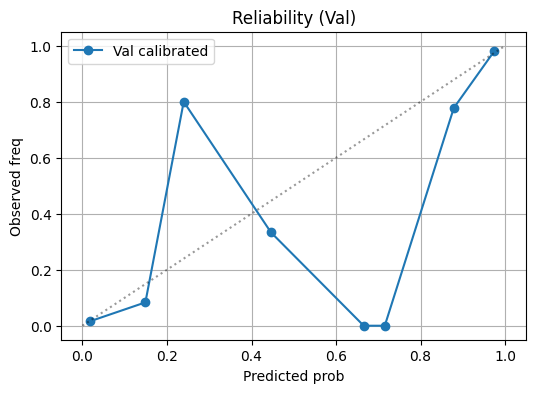

In [10]:
# Cell 11 - ROC curves
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, p_test_cal)
roc_auc_val = auc(fpr,tpr)
plt.plot(fpr, tpr, label=f"Calibrated (Test) AUC={roc_auc_val:.4f}")
# also show base
fpr2, tpr2, _ = roc_curve(y_test, p_test_base)
plt.plot(fpr2, tpr2, label=f"Base (Test) AUC={auc(fpr2,tpr2):.4f}", linestyle="--")
plt.plot([0,1],[0,1], 'k:', alpha=0.4)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Ensemble")
plt.legend(); plt.grid(True)
plt.show()

# reliability curve (optional)
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_val, p_val_cal, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o', label="Val calibrated")
plt.plot([0,1],[0,1],"k:", alpha=0.4)
plt.xlabel("Predicted prob"); plt.ylabel("Observed freq")
plt.title("Reliability (Val)")
plt.grid(True); plt.legend(); plt.show()

In [11]:
# Cell 12 - save fitted models & feature list
out_dir = ROOT / "models"
out_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(base, out_dir / "ensemble_base_lr.joblib")
joblib.dump(calibrator, out_dir / "ensemble_platt_lr.joblib")
# Save features CSV (optional)
df.to_csv(out_dir / "ensemble_features_all_splits.csv", index=False)

print("Saved base and calibrated ensemble models to:", out_dir)
print("Summary AUCs (calibrated):")
print("Train AUC:", train_auc_cal)
print("Val   AUC:", val_auc_cal)
print("Test  AUC:", test_auc_cal)

Saved base and calibrated ensemble models to: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\models
Summary AUCs (calibrated):
Train AUC: 0.9999980631345503
Val   AUC: 0.9916382394541975
Test  AUC: 0.9902117704998769
